# Классификация тональности текста

Для определения тональности применим величины **TF-IDF** как признаки.
Анализ тональности текста, или **сентимент-анализ** (от англ. sentiment, «настроение»), выявляет эмоционально окрашенные слова. Этот инструмент помогает компаниям оценивать, например, реакцию на запуск нового продукта в интернете. На разбор тысячи отзывов человек потратит несколько часов, а компьютер — пару минут.

Оценить тональность — значит отметить текст как позитивный или негативный. То есть мы решаем задачу классификации, где целевой признак равен «1» для положительного текста и «0» для отрицательного. Признаки — это слова из корпуса и их величины TF-IDF для каждого текста.

**Задача:**
- Обучите _логистическую регрессию_ так, чтобы она определяла тональность текста.  
- Подсчитайте величину _TF-IDF_ для текстов. Лемматизированные тексты твитов для обучения находятся в файле tweets_lemm_train.csv. Целевой признак вы найдёте в столбце `positive`.
- Обученной моделью классификации определите результаты _предсказания для тестовой выборки_ твитов, которая лежит в файле tweets_lemm_test.csv. В этой выборке целевого признака нет.
- Сохраните предсказания в столбце `positive`. Таблицу с результатом сохраните как csv-файл, но чтобы тренажёр принял файл, не указывайте расширение (например, назовите файл 'predictions')

Значение `accuracy` вашей модели должно быть не меньше 0.62.

In [1]:
# импорт основных библиотек
import pandas as pd
import matplotlib.pyplot as plt

# импорт спец. библиотек
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#import warnings
#warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 12345

<a id='section_1A'></a>
### Чтение и знакомство с данными

In [2]:
# чтение файлов
df_train = pd.read_csv('datasets/tweets_lemm_train.csv')
df_test  = pd.read_csv('datasets/tweets_lemm_test.csv')
print('Файлы прочитаны.')

Файлы прочитаны.


In [3]:
# знакомство с данными
display(df_train)
display(df_test)

,text,positive,lemm_text
0,"@first_timee хоть я и школота, но поверь, у на...",1,хоть я и школотый но поверь у мы то же самый о...
1,"Да, все-таки он немного похож на него. Но мой ...",1,да весь таки он немного похожий на он но мой м...
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,ну ты идиотка я испугаться за ты
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,кто то в угол сидеть и погибать от голод а мы ...
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1,вот что значит страшилка но блин посмотреть ве...
...,...,...,...
4995,Вроде дружили 10 лет и в один момент все разру...,0,вроде дружить год и в один момент весь разруши...
4996,"@m_gulko \r\nПоэтому и поздравляю заранее, что...",0,поэтому и поздравлять заранее что не получитьс...
4997,"RT @kubudojede: черт, ну зачем они переделали ...",0,черта ну зачем они переделать
4998,"RT @xidewojopiba: Вроде бы и любим друг друга,...",0,вроде бы и любим друг друг и быть вместе не мо...


,text,lemm_text
0,RT @tiredfennel: если криса так интересуют дет...,если крис так интересовать ребёнок то либо они...
1,@xsealord по 200 руб. в месяц можно разместить...,по рубль в месяц можно разместить ссылка на те...
2,"@haosANDlaw @Etishkindyx учитывая, что сейчас ...",учитывать что сейчас преобладать один половина...
3,Товарищ :) Но я никак не могу отдельно не о...,товарищ но я никак не мочь отдельно не отметит...
4,RT @BodyaNick: Квн был отличный !) Оооочень по...,квн быть отличный оооочень понравиться женский...
...,...,...
2995,"жуйк, ачивки в контре — зло! мой младший брат ...",жуйк ачивка в контра зло мой младший брат втян...
2996,Не хочу идти на танцы :( http://t.co/5OdPjbYXOC,не хотеть идти на танец
2997,"На улице пусто!ни людей,ни машин,наверно холод...",на улица пусто ни человек ни машина наверно хо...
2998,По-моему мы и ходили за водкой в три часа за э...,по мой мы и ходить за водка в три час за это ч...


In [4]:
# выделение корпусов
corpus_train = df_train['lemm_text'].values.astype('U')
corpus_test  = df_test['lemm_text'].values.astype('U')

print(corpus_train.shape)
print(corpus_test.shape)

(5000,)
(3000,)


In [5]:
# скачивание стоп слов
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('russian'))

# создание TF-IDF векторизатора с стопсловами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# подготовка обучающей выборки
target = df_train['positive']
features = corpus_train

# выделение валидационной выборки
corpus_train, corpus_valid, target_train, target_valid = train_test_split(features,
                                                                          target,
                                                                          train_size = 0.75,
                                                                          random_state = RANDOM_STATE)
count_tf_idf.fit(corpus_train)
features_train = count_tf_idf.transform(corpus_train)
features_valid = count_tf_idf.transform(corpus_valid)

display(features_train.shape)

(3750, 8053)

In [7]:
# обучение логистической регрессии
model = LogisticRegression(solver='lbfgs', random_state = RANDOM_STATE) # , class_weight='balanced'
model.fit(features_train, target_train)

LogisticRegression(random_state=12345)

In [8]:
# предсказание на валидационной выборке
prediction_valid = model.predict(features_valid)
prediction_train = model.predict(features_train)
print('Точность на валидационной выборке:', accuracy_score(target_valid, prediction_valid))
print('Точность на тренировочной выборке:', accuracy_score(target_train, prediction_train))

Точность на валидационной выборке: 0.6208
Точность на тренировочной выборке: 0.916


In [9]:
# подбор порога
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

best_accuracy = 0
for threshold in thresholds:
    prediction_valid = probabilities_one_valid > threshold
    accuracy = accuracy_score(target_valid, prediction_valid)
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
        best_prediction = prediction_valid

print("Наивысший показатель accuracy = {:.3f}, при смещении порога до значения {:.2f}".format(best_accuracy, best_threshold))

Наивысший показатель accuracy = 0.625, при смещении порога до значения 0.48


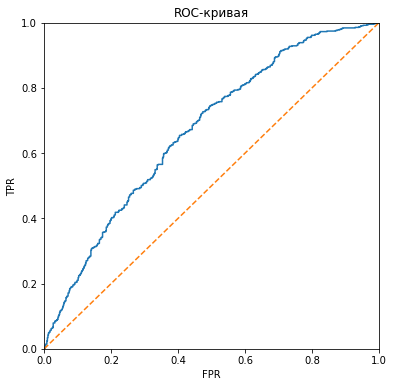

In [10]:
# визуализация кривой ROC_AUC
plt.figure(figsize = (6, 6))
plt.step(fpr, tpr, where='post')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show();

In [14]:
# подготовка тестовой выборки
features_test = count_tf_idf.transform(corpus_test)
display(features_test.toarray().shape)

(3000, 8053)

In [20]:
# предсказание тональности для тестовой выборки с помощью обученной модели
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
prediction_test = probabilities_one_test > best_threshold

(3000, 2)

(3000,)

(3000,)

In [22]:
# сохранение предсказания
prediction_test = pd.DataFrame(prediction_test, columns=['positive'])
display(prediction_test)
prediction_test.to_csv(path_or_buf = 'datasets/predictions.csv')

,positive
0,True
1,True
2,False
3,True
4,True
...,...
2995,True
2996,False
2997,False
2998,False


**План работы:**
- чтение данных для тренировки и создание корпуса и лейблов
- создание векторизатора с стопсловами
- подготовка выборки для обучения с помощью векторизатора
- обучение логистической регрессии на этой выборке
- чтение данных для теста и создание корпуса и лейблов
- предсказание тональности для тестовой выборки с помощью обученной модели
- запись результатов в csv файле ('predictions.csv') с названием столбца предсказаний 'positive'